# Cassava Leaf Disease Classification

Identify the type of disease present on a Cassava Leaf image

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Recommended Tutorial**
We highly recommend [Jesse Mostipak’s Getting Started Tutorial](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) that walks you through making your very first submission step by step.

Link: https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

Help: https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training

In [1]:
import os
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from skimage import io
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
train_df = pd.read_csv("../data/cassava-leaf-disease-classification/train.csv")
train_df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


<IPython.core.display.Javascript object>

In [4]:
train_df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
labels = pd.read_json(
    "../data/cassava-leaf-disease-classification/label_num_to_disease_map.json",
    orient="index",
)
labels

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<IPython.core.display.Javascript object>

## Загрузка и первичная обработка файлов

In [6]:
class CassavaDataset(Dataset):
    """
    see: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    def __init__(self, df, image_dir, transform=None):
        self.cassava_frame = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.cassava_frame)

    def __getitem__(self, idx):
        image_id, label = self.cassava_frame.iloc[idx]

        image_path = os.path.join(self.image_dir, image_id)
        image = io.imread(image_path)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

<IPython.core.display.Javascript object>

In [7]:
X_train, X_test = train_test_split(train_df, test_size=0.1)
X_train, X_val = train_test_split(X_train, test_size=0.1)
X_train.shape, X_val.shape, X_val.shape

((17331, 2), (1926, 2), (1926, 2))

<IPython.core.display.Javascript object>

In [8]:
def get_transform(step=None):
    if step == "train":
        return A.Compose(
            [
                A.Resize(512, 512),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )

    return A.Compose(
        [
            A.Resize(512, 512),
            A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )


BATCH_SIZE = 8

IMAGE_DIR = "../data/cassava-leaf-disease-classification/train_images"

train_dataset = CassavaDataset(
    df=X_train, image_dir=IMAGE_DIR, transform=get_transform("train"),
)

val_dataset = CassavaDataset(df=X_val, image_dir=IMAGE_DIR, transform=get_transform(),)

test_dataset = CassavaDataset(
    df=X_test, image_dir=IMAGE_DIR, transform=get_transform(),
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

len(train_loader), len(val_loader), len(test_loader)

(2166, 241, 268)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


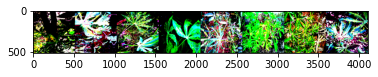

<IPython.core.display.Javascript object>

In [9]:
# https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2
# .. https://stackoverflow.com/a/51331557
images, labels = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))

In [10]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

<IPython.core.display.Javascript object>

## Подготовка и обучение модели

In [11]:
# https://www.kaggle.com/japandata509/ensemble-resnext50-32x4d-efficientnet-0-903


class CassavaClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/vision/stable/models.html#classification
        # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
        self.model = models.resnext50_32x4d(pretrained=False)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 5)

    def forward(self, x):
        x = self.model(x)
        return x

<IPython.core.display.Javascript object>

In [12]:
model = CassavaClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
)

<IPython.core.display.Javascript object>

In [13]:
def step_score(model, loader, desc=""):
    model.eval()

    step_accuracy = 0

    pbar = tqdm(enumerate(loader), total=len(loader))
    if desc:
        pbar.set_description(desc)

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)

        y_pred = y_preds.argmax(dim=1).cpu().detach().numpy()
        y_true = labels.cpu().detach().numpy()

        step_accuracy += (y_pred == y_true).mean()

    return step_accuracy / len(loader)

<IPython.core.display.Javascript object>

In [14]:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# .. https://www.kaggle.com/code/yasufuminakama/cassava-resnext50-32x4d-starter-training

num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description("Epoch %d" % epoch)

    epoch_loss = 0
    epoch_accuracy = 0

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        loss = loss_fn(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = y_preds.argmax(dim=1).cpu().detach().numpy()
        y_true = labels.cpu().detach().numpy()

        epoch_loss += loss.cpu().detach().numpy()
        epoch_accuracy += (y_pred == y_true).mean()

    scheduler.step()

    print(
        "Loss: {}, Train accuracy: {}, Val accuracy: {}".format(
            epoch_loss / len(train_loader),
            epoch_accuracy / len(train_loader),
            step_score(model, val_loader, "Validation"),
        )
    )

  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 1.0941851130125155, Train accuracy: 0.6255771006463527, Val accuracy: 0.6298409405255878


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 1.0094483546974586, Train accuracy: 0.6375230840258541, Val accuracy: 0.6535269709543569


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.9112924851704172, Train accuracy: 0.661645891043398, Val accuracy: 0.6492047026279392


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.8466982247302737, Train accuracy: 0.6824792243767313, Val accuracy: 0.6969225449515907


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.766641376001738, Train accuracy: 0.7128924284395198, Val accuracy: 0.75


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.7012552694105375, Train accuracy: 0.742786241920591, Val accuracy: 0.7551867219917012


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.6351032352620187, Train accuracy: 0.7704293628808865, Val accuracy: 0.7800829875518672


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.5908924678507383, Train accuracy: 0.7850877192982456, Val accuracy: 0.7863070539419087


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.5582995073988497, Train accuracy: 0.798938134810711, Val accuracy: 0.7816390041493776


  0%|          | 0/2166 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Loss: 0.5326554636322203, Train accuracy: 0.808691135734072, Val accuracy: 0.8189834024896265


<IPython.core.display.Javascript object>

## Проверка результатов

In [16]:
test_accuracy = step_score(model, test_loader, "Testing")
test_accuracy

  0%|          | 0/268 [00:00<?, ?it/s]

0.8125

<IPython.core.display.Javascript object>